# CS 229 Final Project

Authors: Imogen Gardiner, Zofia Dudek, Galen Topper

## Project Overview:

Our project involves building machine learning models to improve the prediction of progression of breast cancer.

In [126]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import roc_auc_score, mean_squared_error
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from itertools import product

from utils import datasets, train_and_eval_model, run_hparam_search


#### Processing the data

In [127]:
# Read in the dataset
bc_data = pd.read_csv('breast_msk_2018_clinical_data.tsv', sep='\t') 
cnv_df = pd.read_csv("breast_msk_2018_segments.seg", sep="\t") 
print(bc_data.head())
print(cnv_df.head())

          Study ID Patient ID          Sample ID    Cancer Type  \
0  breast_msk_2018  P-0000004  P-0000004-T01-IM3  Breast Cancer   
1  breast_msk_2018  P-0000012  P-0000012-T02-IM3  Breast Cancer   
2  breast_msk_2018  P-0000015  P-0000015-T01-IM3  Breast Cancer   
3  breast_msk_2018  P-0000041  P-0000041-T01-IM3  Breast Cancer   
4  breast_msk_2018  P-0000057  P-0000057-T01-IM3  Breast Cancer   

                        Cancer Type Detailed  Disease Free Event  \
0           Breast Invasive Ductal Carcinoma                   1   
1           Breast Invasive Ductal Carcinoma                   0   
2           Breast Invasive Ductal Carcinoma                   1   
3           Breast Invasive Ductal Carcinoma                   1   
4  Breast Mixed Ductal and Lobular Carcinoma                   1   

   Disease Free (Months) ER PCT Primary ER Status of Sequenced Sample  \
0                    1.1             70                      Positive   
1                  218.0              0   

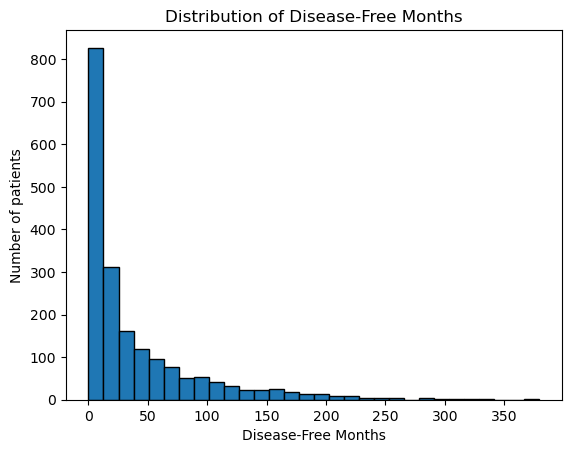

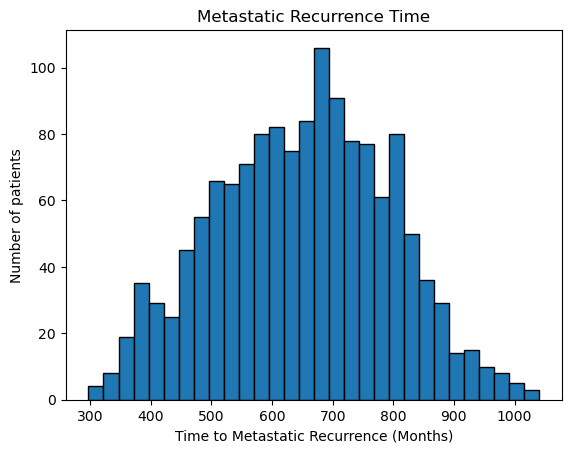

In [128]:
# Visualize the data

# Disease-free months
plt.hist(bc_data['Disease Free (Months)'], bins=30, edgecolor='black')
plt.xlabel('Disease-Free Months')
plt.ylabel('Number of patients')
plt.title('Distribution of Disease-Free Months')
plt.show()

# Metastatic recurrence time
plt.hist(bc_data['Metastatic Recurrence Time'], bins=30, edgecolor='black')
plt.xlabel('Time to Metastatic Recurrence (Months)')
plt.ylabel('Number of patients')
plt.title('Metastatic Recurrence Time')
plt.show()


In [129]:
# Split data into train, valid, test sets
train_idx, valid_idx, test_idx = None, None, None 

train_idx, test_idx = train_test_split(bc_data.index, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)

In [130]:
# Now, split up features and labels
ds_instance = datasets(
    train_X = bc_data.loc[train_idx],
    valid_X = bc_data.loc[valid_idx],
    test_X = bc_data.loc[test_idx],
    train_y = bc_data.loc[train_idx, "Metastatic Recurrence Time"],
    valid_y = bc_data.loc[valid_idx, "Metastatic Recurrence Time"],
    test_y = bc_data.loc[test_idx, "Metastatic Recurrence Time"],
    )

# Preprocess the data

#### Data Preprocessing and Feature Engineering

In [131]:
# Extract genomic features
# Constants
TOTAL_GENOME_LENGTH = 3_200_000_000  # Approximate human genome size in base pairs

# Extract Total number of segments per sample
segments_per_sample = cnv_df.groupby("ID").size().reset_index(name="total_segments")

# Compute Proportion of genome affected per sample
cnv_df["segment_length"] = cnv_df["loc.end"] - cnv_df["loc.start"]
cnv_affected_length = cnv_df.groupby("ID")["segment_length"].sum().reset_index()
cnv_affected_length["proportion_genome_affected"] = cnv_affected_length["segment_length"] / TOTAL_GENOME_LENGTH

# Compute Mean CNV per chromosome per sample
mean_cnv_per_chromosome = cnv_df.groupby(["ID", "chrom"])["seg.mean"].mean().unstack().reset_index()
mean_cnv_per_chromosome.columns = ["ID"] + [f"mean_cnv_chr{c}" for c in mean_cnv_per_chromosome.columns[1:]]

# Merge extracted features
genomic_features = segments_per_sample

genomic_features = genomic_features.merge(cnv_affected_length[["ID", "proportion_genome_affected"]], on="ID")
genomic_features = genomic_features.merge(mean_cnv_per_chromosome, on="ID")

# Merge with clinical table
merged_data = bc_data.merge(genomic_features, left_on="Sample ID", right_on="ID", how="left").drop(columns=["ID"])

# Save the merged dataset
merged_data.to_csv("merged_clinical_genomic_data.csv", index=False)

# Display results
print(merged_data.head())

          Study ID Patient ID          Sample ID    Cancer Type  \
0  breast_msk_2018  P-0000004  P-0000004-T01-IM3  Breast Cancer   
1  breast_msk_2018  P-0000012  P-0000012-T02-IM3  Breast Cancer   
2  breast_msk_2018  P-0000015  P-0000015-T01-IM3  Breast Cancer   
3  breast_msk_2018  P-0000041  P-0000041-T01-IM3  Breast Cancer   
4  breast_msk_2018  P-0000057  P-0000057-T01-IM3  Breast Cancer   

                        Cancer Type Detailed  Disease Free Event  \
0           Breast Invasive Ductal Carcinoma                   1   
1           Breast Invasive Ductal Carcinoma                   0   
2           Breast Invasive Ductal Carcinoma                   1   
3           Breast Invasive Ductal Carcinoma                   1   
4  Breast Mixed Ductal and Lobular Carcinoma                   1   

   Disease Free (Months) ER PCT Primary ER Status of Sequenced Sample  \
0                    1.1             70                      Positive   
1                  218.0              0   

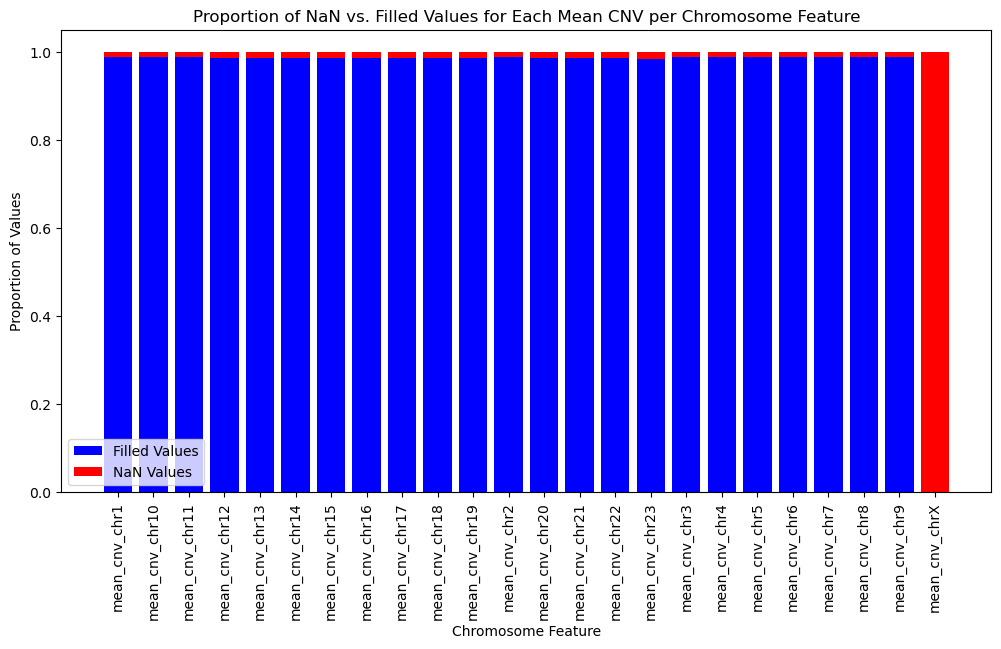

In [132]:
# Select only the mean_cnv_chr columns
mean_cnv_columns = merged_data.filter(like="mean_cnv_chr")

# Set up the figure
plt.figure(figsize=(12, 6))

# Loop through each column and plot its proportion of NaN vs. filled values
for column in mean_cnv_columns.columns:
    nan_count = mean_cnv_columns[column].isna().sum()
    filled_count = mean_cnv_columns[column].notna().sum()
    total = nan_count + filled_count

    # Bar chart for each feature
    plt.bar(column, filled_count / total, color="blue", label="Filled Values" if column == mean_cnv_columns.columns[0] else "")
    plt.bar(column, nan_count / total, bottom=filled_count / total, color="red", label="NaN Values" if column == mean_cnv_columns.columns[0] else "")

# Formatting
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.xlabel("Chromosome Feature")
plt.ylabel("Proportion of Values")
plt.title("Proportion of NaN vs. Filled Values for Each Mean CNV per Chromosome Feature")
plt.legend()
plt.show()

### Linear Regression Model

In [ ]:
y = merged_data["Metastatic Recurrence Time"].dropna() 
X = merged_data

# Remove target variable from features
X = X.drop(columns=["Metastatic Recurrence Time"], errors="ignore")

# Align X and y
X = X.loc[y.index].reset_index(drop=True) 
y = y.reset_index(drop=True)

# Encode categorical variables and ensure all remaining features are numeric
categorical_columns = X.select_dtypes(include=["object"]).columns
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X[categorical_columns] = encoder.fit_transform(X[categorical_columns])
X = X.apply(pd.to_numeric, errors='coerce')

# Features (remove unnecessary columns),
X = X.drop(columns=["Metastatic Disease at Last Follow-up", #overlap with target
"Study ID", "Patient ID", "Sample ID", # IDs not useful for prediction
"Last Communication Contact", # Metadata
# "Patient's Vital Status", # More of an outcome variable than predictive feature and may overlap with target "Somatic Status"
"Number of Samples Per Patient", # No direct predictive value, could introduce noise
"NGS Sample Collection Time Period", # Logisitcal metadata
"Overall Survival (Months)", # More of an outcome variable than predictive feature, may overlap with "Overall Survival Status"
"Time To Death (Months)", # Outcome feature and potential overlap with target
"mean_cnv_chrX" # Mostly Nan values
])

# Define function to perform hyperparameter tuning for linear regression using GridSearchCV
def hyperparameter_search_linear(X_train, y_train, param_grid, inner_cv):
    model = Pipeline([
        ("scaler", StandardScaler()),  
        ("feature_selection", SelectKBest(score_func=f_regression)),  
        ("regressor", Ridge())  
    ])

    search = GridSearchCV(model, param_grid, cv=inner_cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
    search.fit(X_train, y_train)

    return {"best_params": search.best_params_, "best_score": -search.best_score_} # convert negative RMSE to RMSE

param_grid = {
    "feature_selection__k": [10, 15, 20, 25, 30, 35, 40, 45, 50, 55],  
    "regressor": [Ridge(), Lasso(alpha=10, max_iter=5000)],  
    "regressor__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]  
}

hyperparam_results = {}  

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_train_scores = []
rmse_test_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ensure all values are numeric
    X_train = pd.DataFrame(X_train).apply(pd.to_numeric, errors='coerce')
    X_test = pd.DataFrame(X_test).apply(pd.to_numeric, errors='coerce')
    y_train = pd.to_numeric(y_train, errors='coerce')

    # Perform mean imputation of missing values
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Convert back to df 
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

    # Apply mean imputation to the target variable
    y_train = imputer.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Conduct hyperparameter tuning using inner cross-validation
    search_results = hyperparameter_search_linear(X_train, y_train, param_grid, inner_cv=5)
    best_params = search_results["best_params"]
    print(f"Best Params (Inner CV): {best_params}, Best Validation RMSE: {search_results['best_score']:.4f}")

    # Use SelectKBest with best k found during hyperparameter search
    selector = SelectKBest(score_func=f_regression, k=best_params["feature_selection__k"])
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    selected_features = X.columns[selector.get_support()]
    print(f"Top {best_params['feature_selection__k']} selected features: {list(selected_features)}")

    # Train model with best hyperparameters from search
    best_model = best_params["regressor"].set_params(alpha=best_params["regressor__alpha"])
    best_model.fit(X_train_selected, y_train)

    # Predict on selected features
    y_train_pred = best_model.predict(X_train_selected)
    y_test_pred = best_model.predict(X_test_selected)

    # Evaluate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_train_scores.append(train_rmse)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rmse_test_scores.append(test_rmse)

    # Store RMSE in dict
    hyperparam_results[(best_params["feature_selection__k"], best_params["regressor__alpha"])] = test_rmse

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    
# Report final results
print(f"Mean Train RMSE: {np.mean(rmse_train_scores):.4f}")
print(f"Mean Test RMSE: {np.mean(rmse_test_scores):.4f}")

Plot linear regression model 

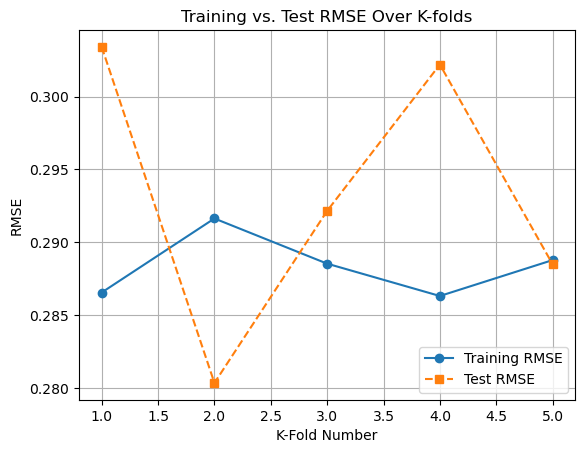

In [119]:
# Create an iteration index (e.g., fold numbers)
iterations = range(1, len(rmse_train_scores) + 1)

# Plot Training RMSE
plt.plot(iterations, rmse_train_scores, label="Training RMSE", marker='o', linestyle='-')

# Plot Test RMSE
plt.plot(iterations, rmse_test_scores, label="Test RMSE", marker='s', linestyle='--')

# Formatting the plot
plt.xlabel("K-Fold Number")
plt.ylabel("RMSE")
plt.title("Training vs. Test RMSE Over K-folds")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### Training an XGBoost model
We have many missing values, which XGBoost can handle well.

[0]	train-rmse:128.49558	valid-rmse:132.24791


/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


[10]	train-rmse:49.45776	valid-rmse:56.06226
[20]	train-rmse:20.99815	valid-rmse:33.38377
[30]	train-rmse:10.34374	valid-rmse:27.52395
[40]	train-rmse:5.93962	valid-rmse:25.07183
[50]	train-rmse:4.00422	valid-rmse:23.95817
[60]	train-rmse:2.97059	valid-rmse:23.40952
[70]	train-rmse:2.40091	valid-rmse:23.15680
[80]	train-rmse:2.00578	valid-rmse:22.96642
[90]	train-rmse:1.70790	valid-rmse:22.89344
[99]	train-rmse:1.43617	valid-rmse:22.83958

Final RMSE Scores:
Train RMSE: 1.44
Validation RMSE: 22.84

Model Performance Metrics:
Training RMSE: 1.44
Training R² Score: 1.00
Validation RMSE: 22.84
Validation R² Score: 0.98
Test RMSE: 16.07
Test R² Score: 0.99


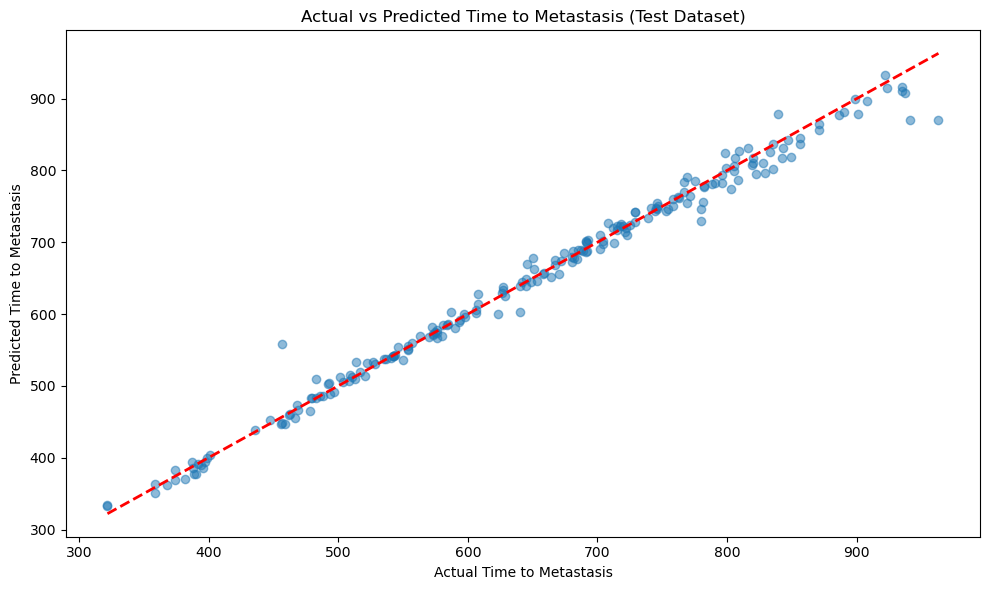

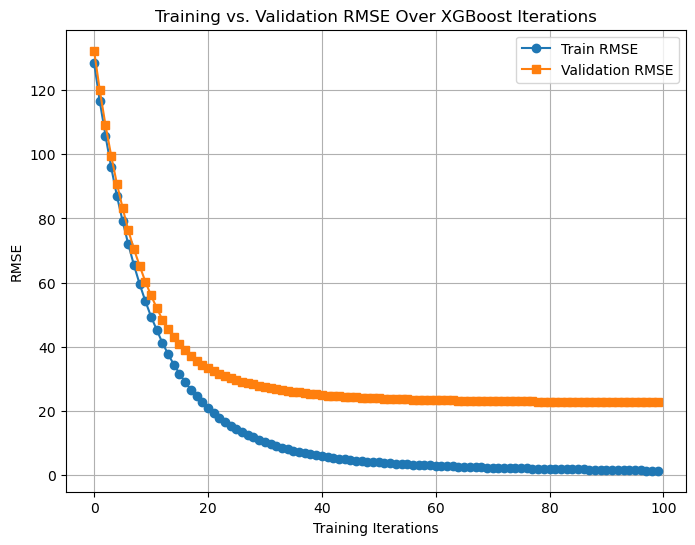

In [ ]:
y = merged_data["Metastatic Recurrence Time"].dropna()
X = merged_data.drop(columns=["Metastatic Recurrence Time"], errors="ignore")
X = X.loc[y.index].reset_index(drop=True)
y = y.reset_index(drop=True)

X = X.apply(pd.to_numeric, errors="coerce")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 1
}

# Train XGBoost model
num_rounds = 100
evals_result = {}  # RMSE results 
model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=10,  # Stops if RMSE stops improving
    evals_result=evals_result,
    verbose_eval=10
)

# Make predictions
train_preds = model.predict(dtrain)
valid_preds = model.predict(dvalid)
test_preds = model.predict(dtest)

# Calculate performance metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} RMSE: {rmse:.2f}")
    print(f"{dataset_name} R² Score: {r2:.2f}")
    return rmse, r2

# RMSE during training
print("\nFinal RMSE Scores:")
print(f"Train RMSE: {evals_result['train']['rmse'][-1]:.2f}")
print(f"Validation RMSE: {evals_result['valid']['rmse'][-1]:.2f}")

print("\nModel Performance Metrics:")
train_rmse, train_r2 = calculate_metrics(y_train, train_preds, "Training")
valid_rmse, valid_r2 = calculate_metrics(y_valid, valid_preds, "Validation")
test_rmse, test_r2 = calculate_metrics(y_test, test_preds, "Test")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Time to Metastasis")
plt.ylabel("Predicted Time to Metastasis")
plt.title("Actual vs Predicted Time to Metastasis (Test Dataset)")
plt.tight_layout()
plt.show()

# Plot RMSE vs Training Iterations
plt.figure(figsize=(8,6))
plt.plot(evals_result["train"]["rmse"], label="Train RMSE", marker="o")
plt.plot(evals_result["valid"]["rmse"], label="Validation RMSE", marker="s")

plt.xlabel("Training Iterations")
plt.ylabel("RMSE")
plt.title("Training vs. Validation RMSE Over XGBoost Iterations")
plt.legend()
plt.grid(True)
plt.show()


#### Addressing overfitting
To address overfitting, we will run a hyperparameter search and retrain the model on the best hyperparameters found.

In [121]:
# Define target variable
y = merged_data["Metastatic Recurrence Time"].dropna()
X = merged_data.drop(columns=["Metastatic Recurrence Time"], errors="ignore")

# Align features and target 
X = X.loc[y.index].reset_index(drop=True)
y = y.reset_index(drop=True)

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors="coerce")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Hyperparameter grid
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "min_child_weight": [1]
}

# Generate all combinations of hyperparameters
param_combinations = list(product(
    param_grid["max_depth"],
    param_grid["learning_rate"],
    param_grid["n_estimators"]
))

best_rmse = float("inf")
best_params = None

# Perform hyperparameter search
for max_depth, learning_rate, n_estimators in param_combinations:
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "min_child_weight": 1
    }

    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=n_estimators,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        evals_result=evals_result,
        early_stopping_rounds=10,
        verbose_eval=False
    )

    # Get validation RMSE
    final_valid_rmse = evals_result["valid"]["rmse"][-1]

    # Check if this is the best model
    if final_valid_rmse < best_rmse:
        best_rmse = final_valid_rmse
        best_params = params

# Print the best hyperparameters
print("\nBest Hyperparameters Found:")
print(best_params)
print(f"Best Validation RMSE: {best_rmse:.2f}")


/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:00:11] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/imogengardiner/anaconda3/envs/202env/li


Best Hyperparameters Found:
{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1}
Best Validation RMSE: 10.54


Train XGBoost with Optimal Hyperparameters

[0]	train-rmse:128.88846	valid-rmse:132.50341
[10]	train-rmse:54.45127	valid-rmse:58.66223
[20]	train-rmse:29.41951	valid-rmse:36.36657
[30]	train-rmse:19.99743	valid-rmse:28.47292
[40]	train-rmse:15.21332	valid-rmse:23.52555
[50]	train-rmse:12.56296	valid-rmse:21.03620
[60]	train-rmse:10.63633	valid-rmse:19.01830
[70]	train-rmse:9.44541	valid-rmse:17.71084
[80]	train-rmse:8.45392	valid-rmse:16.68353
[90]	train-rmse:7.66250	valid-rmse:15.76499
[100]	train-rmse:7.05565	valid-rmse:15.22314
[110]	train-rmse:6.63551	valid-rmse:14.78755
[120]	train-rmse:6.23375	valid-rmse:14.44672
[130]	train-rmse:5.85114	valid-rmse:14.18984
[140]	train-rmse:5.52314	valid-rmse:13.95663
[150]	train-rmse:5.25783	valid-rmse:13.94927
[160]	train-rmse:5.02477	valid-rmse:13.80986


/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:00:21] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[170]	train-rmse:4.83701	valid-rmse:13.69314
[180]	train-rmse:4.62762	valid-rmse:13.55672
[190]	train-rmse:4.42176	valid-rmse:13.46385
[199]	train-rmse:4.25366	valid-rmse:13.35522
Optimized Test RMSE: 12.39


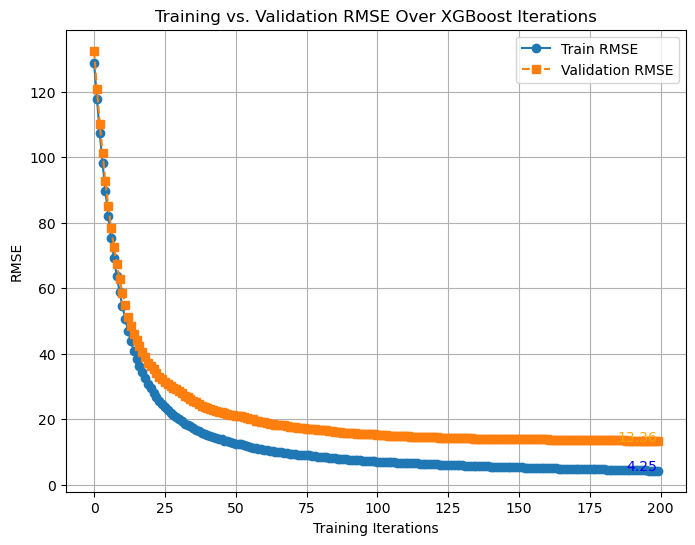


Final Model Performance:
Training RMSE: 4.25
Training R² Score: 1.00
Validation RMSE: 13.36
Validation R² Score: 0.99
Test RMSE: 12.39
Test R² Score: 0.99


In [ ]:
# Define target variable
y = merged_data["Metastatic Recurrence Time"].dropna()
X = merged_data.drop(columns=["Metastatic Recurrence Time"], errors="ignore")

# Align features with target
X = X.loc[y.index].reset_index(drop=True)
y = y.reset_index(drop=True)

# Convert to numeric
X = X.apply(pd.to_numeric, errors="coerce")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

# Ensure best_params contains valid hyperparameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": best_params.get("max_depth", 6),
    "learning_rate": best_params.get("learning_rate", 0.1),
    "n_estimators": best_params.get("n_estimators", 100),
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 1
}

# Train the optimized XGBoost model
evals_result = {}
model_optimized = xgb.train(
    params,
    dtrain,
    num_boost_round=params["n_estimators"],  # Use tuned n_estimators
    evals=[(dtrain, "train"), (dvalid, "valid")],
    evals_result=evals_result,
    early_stopping_rounds=10,
    verbose_eval=10
)

# Generate test predictions
test_preds_optimized = model_optimized.predict(dtest)

# Validate shape before RMSE calculation
if len(test_preds_optimized) != len(y_test):
    print(f"Warning: Size mismatch - Predictions: {len(test_preds_optimized)}, y_test: {len(y_test)}")
    
    # Align predictions to the size of y_test (only needed if minor mismatches exist)
    min_length = min(len(test_preds_optimized), len(y_test))
    test_preds_optimized = test_preds_optimized[:min_length]
    y_test = y_test.iloc[:min_length]

# Compute Test RMSE
test_rmse_optimized = np.sqrt(mean_squared_error(y_test, test_preds_optimized))
print(f"Optimized Test RMSE: {test_rmse_optimized:.2f}")

# Plot RMSE for Train, Validation, and Test
plt.figure(figsize=(8,6))
plt.plot(evals_result["train"]["rmse"], label="Train RMSE", marker="o", linestyle="-")
plt.plot(evals_result["valid"]["rmse"], label="Validation RMSE", marker="s", linestyle="--")

# Add text labels for RMSE values
final_train_rmse = evals_result["train"]["rmse"][-1]
final_valid_rmse = evals_result["valid"]["rmse"][-1]

plt.text(len(evals_result["train"]["rmse"]) - 1, final_train_rmse, f"{final_train_rmse:.2f}", fontsize=10, ha="right", color="blue")
plt.text(len(evals_result["valid"]["rmse"]) - 1, final_valid_rmse, f"{final_valid_rmse:.2f}", fontsize=10, ha="right", color="orange")

plt.xlabel("Training Iterations")
plt.ylabel("RMSE")
plt.title("Training vs. Validation RMSE Over XGBoost Iterations")
plt.legend()
plt.grid(True)
plt.show()

# Print model performance
def calculate_metrics(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} RMSE: {rmse:.2f}")
    print(f"{dataset_name} R² Score: {r2:.2f}")
    return rmse, r2

print("\nFinal Model Performance:")
train_preds_optimized = model_optimized.predict(dtrain)
valid_preds_optimized = model_optimized.predict(dvalid)

train_rmse, train_r2 = calculate_metrics(y_train, train_preds_optimized, "Training")
valid_rmse, valid_r2 = calculate_metrics(y_valid, valid_preds_optimized, "Validation")
test_rmse, test_r2 = calculate_metrics(y_test, test_preds_optimized, "Test")

#### Training a Random Survival Forest Model


Overall Survival - Concordance index: 0.882


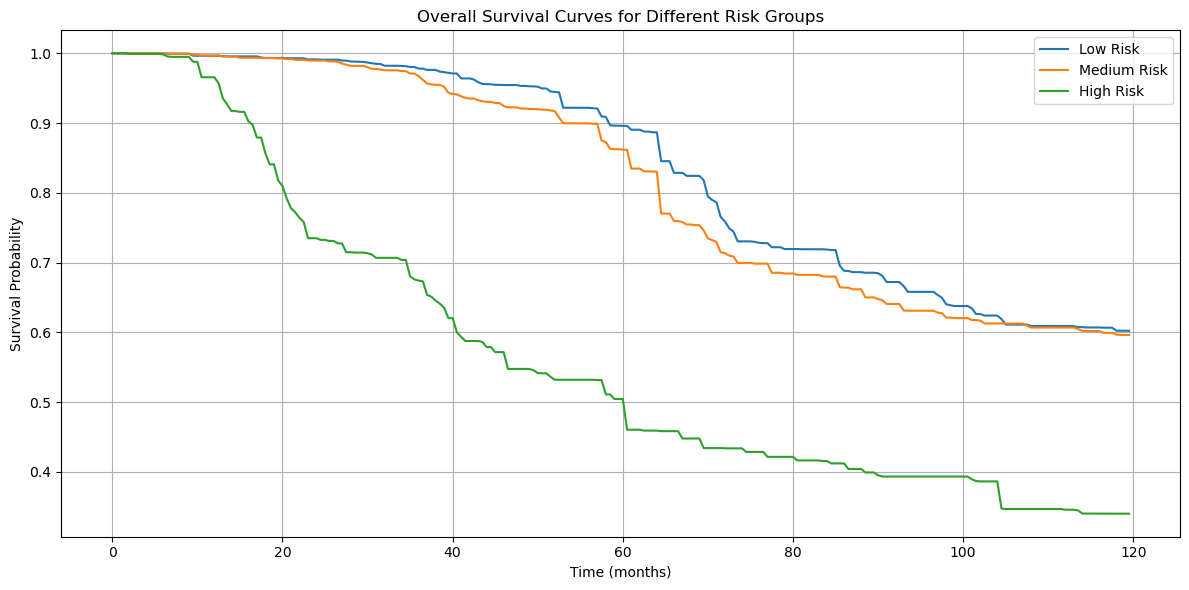


Cross-validation Results:
Overall Survival CV concordance index: 0.865 ± 0.010


In [124]:
data = pd.read_csv('merged_clinical_genomic_data.csv')

y_os = np.array(
    [(str(status).strip().lower() == "deceased", float(time))
     for status, time in zip(data["Patient's Vital Status"], data["Overall Survival (Months)"])],
    dtype=[("event", "bool"), ("time", "float")]
)
valid_os_indices = ~np.isnan(data["Overall Survival (Months)"])
y_os = y_os[valid_os_indices]
data_os = data.loc[valid_os_indices]

X_os = data_os[features_to_include]

X_os = pd.get_dummies(X_os, drop_first=True)
X_os = X_os.fillna(X_os.median())
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size=0.2, random_state=42)

random_forest_os = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
random_forest_os.fit(X_train_os, y_train_os)

c_index_os = concordance_index_censored(y_test_os["event"], y_test_os["time"], random_forest_os.predict(X_test_os))
print(f"Overall Survival - Concordance index: {c_index_os[0]:.3f}")

test_pred_os = random_forest_os.predict(X_test_os)
risk_scores_os = pd.Series(test_pred_os)
risk_groups_os = pd.qcut(risk_scores_os, 3, labels=['Low Risk', 'Medium Risk', 'High Risk'])

plt.figure(figsize=(12, 6))
times = np.arange(0, 120, 0.5)

for risk_group in ['Low Risk', 'Medium Risk', 'High Risk']:
    indices = np.where(risk_groups_os == risk_group)[0]
    
    if len(indices) > 0:
        sample_idx = indices[0]
        patient_features = X_test_os.iloc[sample_idx:sample_idx+1]
        
        survival_func = random_forest_os.predict_survival_function(patient_features)[0]
        survival_probs = survival_func(times)
        
        plt.plot(times, survival_probs, label=f"{risk_group}")

plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title('Overall Survival Curves for Different Risk Groups')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nCross-validation Results:")

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_os = []

for train_idx, test_idx in k_fold.split(X_os):
    X_train_cv, X_test_cv = X_os.iloc[train_idx], X_os.iloc[test_idx]
    y_train_cv, y_test_cv = y_os[train_idx], y_os[test_idx]
    
    rsf_cv = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)
    rsf_cv.fit(X_train_cv, y_train_cv)
    
    pred_cv = rsf_cv.predict(X_test_cv)
    c_index_cv = concordance_index_censored(y_test_cv["event"], y_test_cv["time"], pred_cv)
    cv_scores_os.append(c_index_cv[0])

print(f"Overall Survival CV concordance index: {np.mean(cv_scores_os):.3f} ± {np.std(cv_scores_os):.3f}")

Tuning Random Survival Forest parameters...
n_estimators=50, max_depth=None, C-index=0.867
n_estimators=50, max_depth=3, C-index=0.828
n_estimators=50, max_depth=5, C-index=0.843
n_estimators=50, max_depth=7, C-index=0.872
n_estimators=50, max_depth=10, C-index=0.861
n_estimators=50, max_depth=15, C-index=0.871
n_estimators=100, max_depth=None, C-index=0.878
n_estimators=100, max_depth=3, C-index=0.856
n_estimators=100, max_depth=5, C-index=0.854
n_estimators=100, max_depth=7, C-index=0.874
n_estimators=100, max_depth=10, C-index=0.875
n_estimators=100, max_depth=15, C-index=0.877
n_estimators=200, max_depth=None, C-index=0.882
n_estimators=200, max_depth=3, C-index=0.853
n_estimators=200, max_depth=5, C-index=0.863
n_estimators=200, max_depth=7, C-index=0.871
n_estimators=200, max_depth=10, C-index=0.881
n_estimators=200, max_depth=15, C-index=0.882
n_estimators=300, max_depth=None, C-index=0.883
n_estimators=300, max_depth=3, C-index=0.854
n_estimators=300, max_depth=5, C-index=0.864

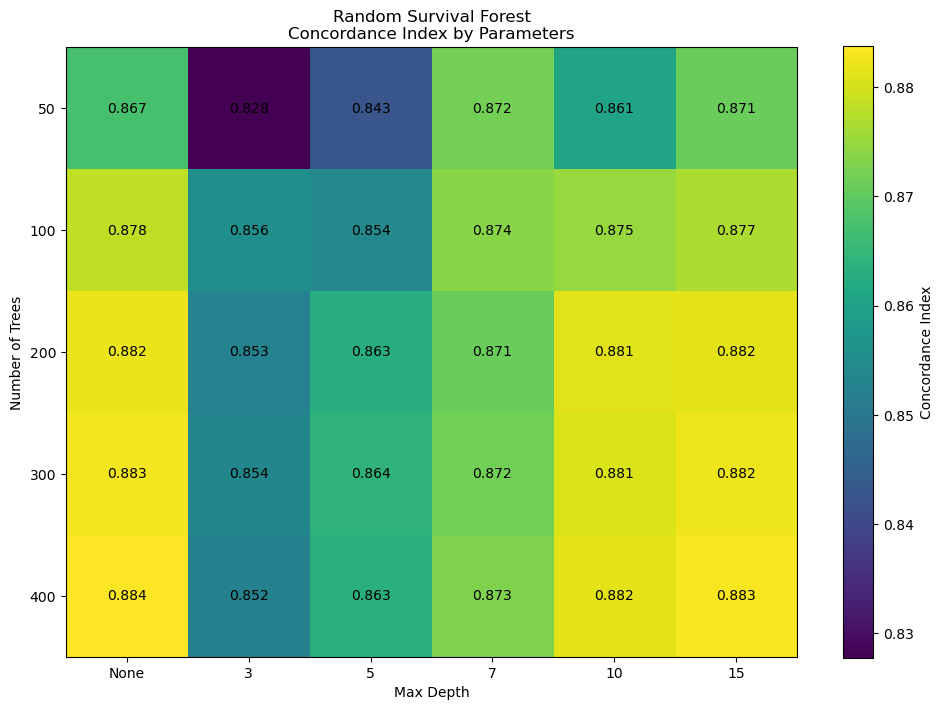

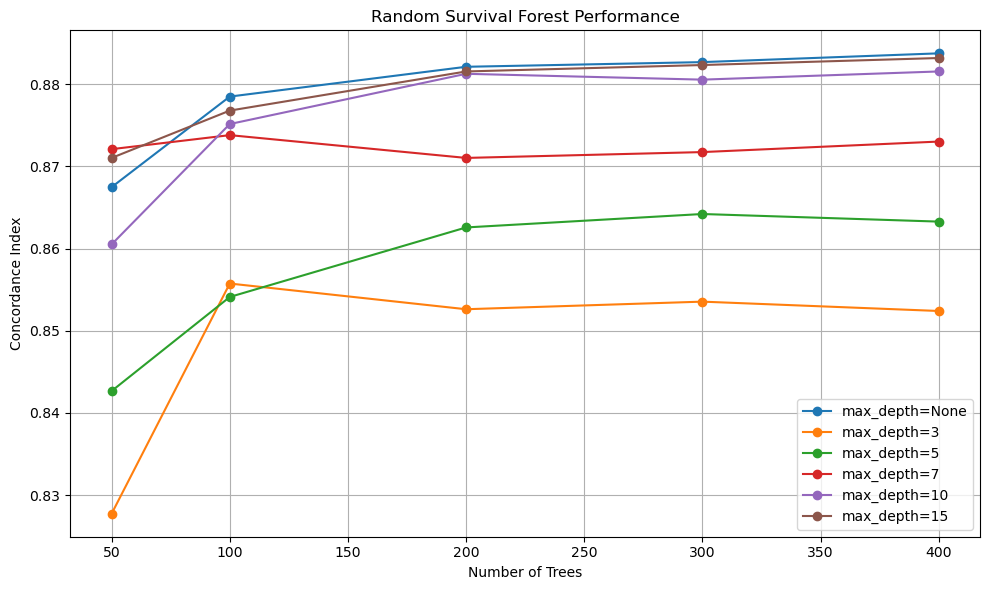

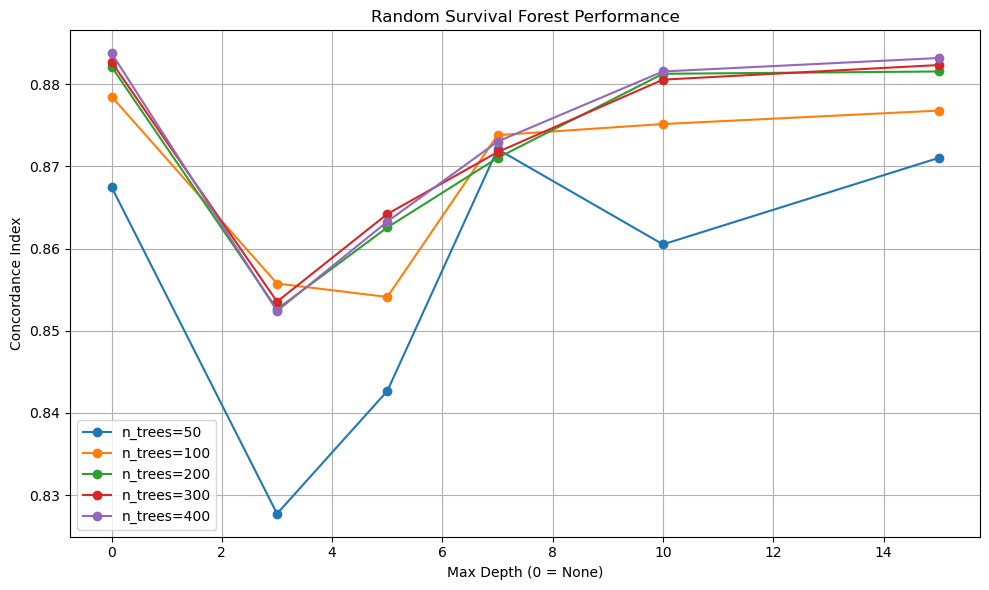


Optimal parameters for Random Survival Forest:
n_estimators = 400
max_depth = None
Best Concordance Index: 0.8837


In [ ]:
n_estimators_list = [50, 100, 200, 300, 400]
max_depth_list = [None, 3, 5, 7, 10, 15]

survival_results = np.zeros((len(n_estimators_list), len(max_depth_list)))

print("Tuning Random Survival Forest parameters...")
for i, n_est in enumerate(n_estimators_list):
    for j, depth in enumerate(max_depth_list):
        rsf = RandomSurvivalForest(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
        rsf.fit(X_train_os, y_train_os)
        pred = rsf.predict(X_test_os)
        c_index = concordance_index_censored(y_test_os["event"], y_test_os["time"], pred)
        survival_results[i, j] = c_index[0]
        print(f"n_estimators={n_est}, max_depth={depth}, C-index={c_index[0]:.3f}")

plt.figure(figsize=(10, 7))

im = plt.imshow(survival_results, cmap='viridis', interpolation='nearest')
plt.title('Random Survival Forest\nConcordance Index by Parameters')
plt.xlabel('Max Depth')
plt.ylabel('Number of Trees')
plt.xticks(np.arange(len(max_depth_list)), [str(d) if d is not None else "None" for d in max_depth_list])
plt.yticks(np.arange(len(n_estimators_list)), n_estimators_list)

cbar = plt.colorbar(im)
cbar.set_label('Concordance Index')

for i in range(len(n_estimators_list)):
    for j in range(len(max_depth_list)):
        plt.text(j, i, f"{survival_results[i, j]:.3f}", 
                 ha="center", va="center", color="white" if survival_results[i, j] < 0.7 else "black")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for j, depth in enumerate(max_depth_list):
    depth_label = str(depth) if depth is not None else "None"
    plt.plot(n_estimators_list, survival_results[:, j], marker='o', label=f'max_depth={depth_label}')

plt.xlabel('Number of Trees')
plt.ylabel('Concordance Index')
plt.title('Random Survival Forest Performance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

max_depth_list_plot = [0 if d is None else d for d in max_depth_list] 

for i, n_est in enumerate(n_estimators_list):
    plt.plot(max_depth_list_plot, survival_results[i, :], marker='o', label=f'n_trees={n_est}')

plt.xlabel('Max Depth (0 = None)')
plt.ylabel('Concordance Index')
plt.title('Random Survival Forest Performance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

best_surv_idx = np.unravel_index(np.argmax(survival_results), survival_results.shape)

print(f"\nOptimal parameters for Random Survival Forest:")
print(f"n_estimators = {n_estimators_list[best_surv_idx[0]]}")
print(f"max_depth = {max_depth_list[best_surv_idx[1]]}")
print(f"Best Concordance Index: {survival_results[best_surv_idx]:.4f}")